In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pprint as pp
import glob as gb
import re
import os

from scipy import signal
%matplotlib inline

# Load Experimental Design

In [2]:
df = pd.read_csv('ScreeningDesign.csv', index_col='Sample ID') 
df.head()

,StdOrder,RunOrder,CenterPt,Blocks,Er,Yb,Deposition Time,Pressure
Sample ID,,,,,,,,
T2,5,1,1,1,-1,-1,1,1
T4,4,2,1,1,1,1,-1,-1
T5,1,3,1,1,-1,-1,-1,-1
T6,8,4,1,1,1,1,1,1
T7,2,5,1,1,1,-1,-1,1


# Load PL Spectrometer Data
## Lifetime

In [3]:
# Lifetime function
from scipy.optimize import curve_fit

def model_func(t, a, b, c):
    return a*np.exp(-t/b)+c

def getLifetime(time, intensity, f):
    try:
        guess = [max(intensity), 10, min(intensity)]
        popt, pcov = curve_fit(model_func, time, intensity, guess)
        return popt[1]
    except:
        print(f + ' did not fit a single exp :(')
        return np.NaN

In [4]:
# Load lifetime files function
def loadLifetime(folder, plot = True):
    
    # Get list of files
    files = gb.glob('./PL_Spectrometer/Lifetime/%s/*.txt' % folder)
    
    # Sort by number
    files = sorted(files, key=lambda x: int(x[len(os.path.dirname(files[1]))+2:-4]))
    
    # Create plotting figure
    if plot:
        f, axarr = plt.subplots(2, sharex=True, figsize=(15,15))
        axarr[0].set_title('With Pump')
        axarr[1].set_title('After Pump - lifetime calculation')

    name = []; decay = [];
    for file in files:
        lifetimeData = np.genfromtxt(fname=file, delimiter=',', dtype=float, skip_header=22, usecols=(0,1))

        # Get sample name
        sample = os.path.split(file)[1]         # Remove path
        sample = sample[:-4]                 # Remove .txt extension
        name.append(sample)
        
        # Get lifetimes
        time = lifetimeData[:,0]/1E6  # Convert to ms
        intensity = lifetimeData[:,1]
        intensity = intensity - min(intensity) # Remove baseline
        
        ind = np.where(time >= float(folder))
        tau = getLifetime(time[ind], intensity[ind], file)
        
        if plot:
            axarr[0].plot(time, intensity)
            axarr[1].plot(time[ind], intensity[ind])
            
        decay.append(tau)

    return pd.Series(decay,index=name) 

,StdOrder,RunOrder,CenterPt,Blocks,Er,Yb,Deposition Time,Pressure,Lifetime_100us
Sample ID,,,,,,,,,
T2,5,1,1,1,-1,-1,1,1,12.478841
T4,4,2,1,1,1,1,-1,-1,1.541386
T5,1,3,1,1,-1,-1,-1,-1,12.971973
T6,8,4,1,1,1,1,1,1,10.131770
T7,2,5,1,1,1,-1,-1,1,10.870046


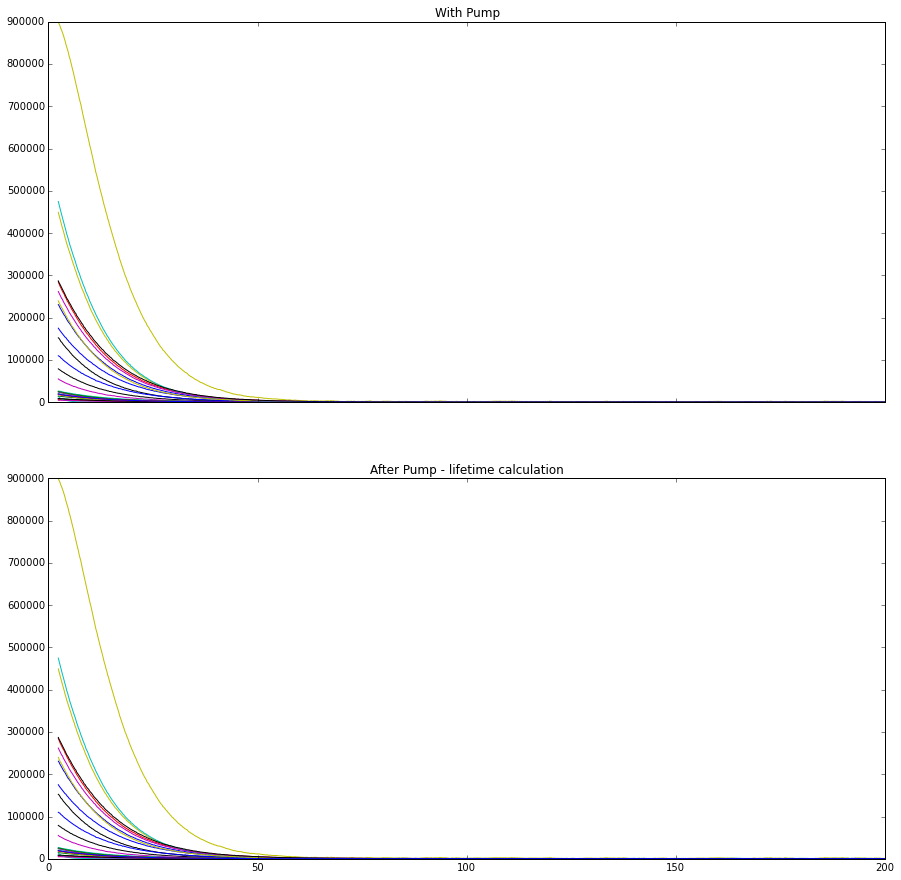

In [7]:
# Store decay into dataframe
df['Lifetime_100us'] = loadLifetime(0.1, plot=True)
# df['Lifetime_2ms'] = loadLifetime(2)
# df['Lifetime_100ms'] = loadLifetime(100)
df.head()

# UV-VIS Spectrometer

## Reflection

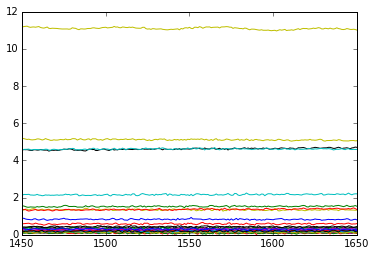

In [8]:
# Get list of files
files = gb.glob('./UV-VIS_Spectrometer/Reflection/T*.csv')

name = []; reflectionAvg = [];
for file in files:
    # Get sample name
    sample = os.path.split(file)[1]     # Remove path
    sample = sample.split('.')[0]       # Remove .txt extension
    
    name.append(sample)
    
    # Load data
    spectrumData = np.genfromtxt(fname=file, delimiter=',', dtype=float, skip_header=1)
    wavelength = spectrumData[:,0]
    reflection = spectrumData[:,1]
    
    # Average between 1450 and 1650nm
    ind = np.where((wavelength >= 1450) & (wavelength <= 1650))
    reflectionAvg.append(np.mean(reflection[ind]))
    
    plt.plot(wavelength[ind], reflection[ind])
    
df['Reflection'] =  pd.Series(reflectionAvg, index=name) 

## Transmission

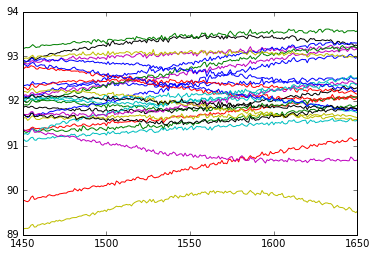

In [9]:
# Get list of files
files = gb.glob('./UV-VIS_Spectrometer/Transmission/T*.csv')

name = []; reflectionAvg = [];

for file in files:
    # Get sample name
    sample = os.path.split(file)[1]     # Remove path
    sample = sample.split('.')[0]       # Remove .txt extension
    
    name.append(sample)
    
    # Load data
    spectrumData = np.genfromtxt(fname=file, delimiter=',', dtype=float, skip_header=1)
    wavelength = spectrumData[:,0]
    reflection = spectrumData[:,1]
    
    # Average between 1450 and 1650nm
    ind = np.where((wavelength >= 1450) & (wavelength <= 1650))
    reflectionAvg.append(np.mean(reflection[ind]))
    
    plt.plot(wavelength[ind], reflection[ind])
    
df['Transmission'] =  pd.Series(reflectionAvg, index=name) 

# Prism Coupler

In [10]:
df1 = pd.read_csv('./Prism_Coupler/550nm.csv', index_col=0) 
df = df.join(df1)
df.head()

,StdOrder,RunOrder,CenterPt,Blocks,Er,Yb,Deposition Time,Pressure,Lifetime_100us,Reflection,Transmission,n,d
Sample ID,,,,,,,,,,,,,
T2,5,1,1,1,-1,-1,1,1,12.478841,0.173160,92.644947,1.5881,1.0821
T4,4,2,1,1,1,1,-1,-1,1.541386,0.240195,90.473665,1.6868,0.6425
T5,1,3,1,1,-1,-1,-1,-1,12.971973,0.171110,92.162333,1.5801,0.7351
T6,8,4,1,1,1,1,1,1,10.131770,0.305797,90.872803,1.6613,1.2078
T7,2,5,1,1,1,-1,-1,1,10.870046,0.138847,93.050809,1.6191,0.4802


In [14]:
df['Absorption'] = 100 - (df['Reflection'] + df['Transmission'])
df.head()

,StdOrder,RunOrder,CenterPt,Blocks,Er,Yb,Deposition Time,Pressure,Lifetime_100us,Reflection,Transmission,n,d,Absorption
Sample ID,,,,,,,,,,,,,,
T2,5,1,1,1,-1,-1,1,1,12.478841,0.173160,92.644947,1.5881,1.0821,7.181894
T4,4,2,1,1,1,1,-1,-1,1.541386,0.240195,90.473665,1.6868,0.6425,9.286140
T5,1,3,1,1,-1,-1,-1,-1,12.971973,0.171110,92.162333,1.5801,0.7351,7.666557
T6,8,4,1,1,1,1,1,1,10.131770,0.305797,90.872803,1.6613,1.2078,8.821400
T7,2,5,1,1,1,-1,-1,1,10.870046,0.138847,93.050809,1.6191,0.4802,6.810344


# Save Dataframe

In [15]:
# Save Dataframe
df.to_csv('Screening.csv')
df.head()

,StdOrder,RunOrder,CenterPt,Blocks,Er,Yb,Deposition Time,Pressure,Lifetime_100us,Reflection,Transmission,n,d,Absorption
Sample ID,,,,,,,,,,,,,,
T2,5,1,1,1,-1,-1,1,1,12.478841,0.173160,92.644947,1.5881,1.0821,7.181894
T4,4,2,1,1,1,1,-1,-1,1.541386,0.240195,90.473665,1.6868,0.6425,9.286140
T5,1,3,1,1,-1,-1,-1,-1,12.971973,0.171110,92.162333,1.5801,0.7351,7.666557
T6,8,4,1,1,1,1,1,1,10.131770,0.305797,90.872803,1.6613,1.2078,8.821400
T7,2,5,1,1,1,-1,-1,1,10.870046,0.138847,93.050809,1.6191,0.4802,6.810344


In [16]:
# To load
df = pd.read_csv('Screening.csv', index_col=0) 
df.head()

# To Sort
# df.sort_values(['RunOrder']);

,StdOrder,RunOrder,CenterPt,Blocks,Er,Yb,Deposition Time,Pressure,Lifetime_100us,Reflection,Transmission,n,d,Absorption
Sample ID,,,,,,,,,,,,,,
T2,5,1,1,1,-1,-1,1,1,12.478841,0.173160,92.644947,1.5881,1.0821,7.181894
T4,4,2,1,1,1,1,-1,-1,1.541386,0.240195,90.473665,1.6868,0.6425,9.286140
T5,1,3,1,1,-1,-1,-1,-1,12.971973,0.171110,92.162333,1.5801,0.7351,7.666557
T6,8,4,1,1,1,1,1,1,10.131770,0.305797,90.872803,1.6613,1.2078,8.821400
T7,2,5,1,1,1,-1,-1,1,10.870046,0.138847,93.050809,1.6191,0.4802,6.810344
